# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden 12 July 2020 - Review required

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
TODO: Complete GitHub automation. Progress: can install all libaries with conda, but issue running this complex notebook remotely. Move to a flat python file next.

Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive_model_action.yaml` to run remotely.

In [2]:
us_run = True

In [3]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirments.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. Remote run is not required. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [4]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [6]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [09:42<00:00,  6.18draws/s]


## Summarize Model Output

In [7]:
result = []
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

100%|██████████| 800/800 [00:02<00:00, 390.10it/s]


,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-05,1.056917,1.050958,0.885891,1.242120,168.859198,173.292876,80.728977,300.0,9175.0
2020-07-06,1.056909,1.052083,0.880851,1.254084,171.305046,175.801993,115.732557,165.0,3520.0
2020-07-07,1.058148,1.049630,0.868164,1.249218,173.853049,178.259189,123.890527,210.0,4185.0
2020-07-08,1.060190,1.044111,0.873044,1.261618,176.527488,180.685001,120.022880,212.0,4361.0
2020-07-09,1.060721,1.044543,0.831642,1.231162,179.384650,183.098194,157.710849,371.0,5808.0
2020-07-10,1.061286,1.049510,0.857295,1.271968,182.475089,185.520204,139.881509,266.0,4695.0
2020-07-11,1.060152,1.044543,0.809886,1.237222,185.811941,187.973708,181.078441,397.0,5413.0
2020-07-12,1.058812,1.044448,0.805860,1.241398,189.383802,190.478598,197.442624,319.0,3989.0
2020-07-13,1.060553,1.047459,0.802209,1.252875,193.165543,193.050247,145.744847,268.0,4540.0


## Plot Model Output

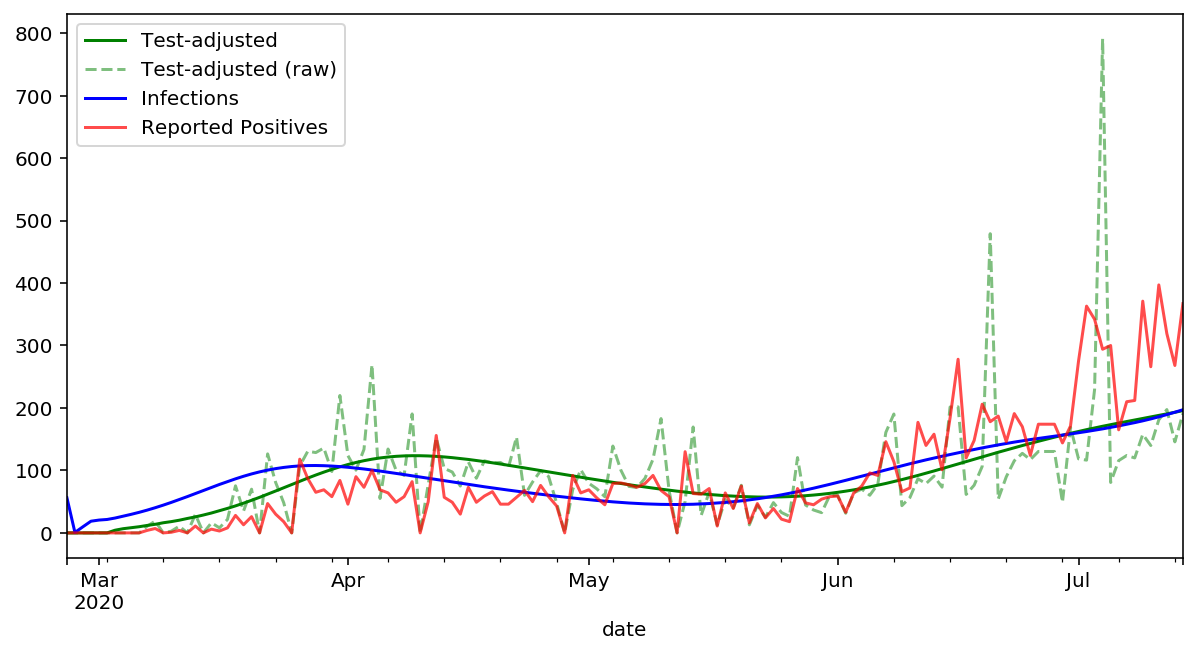

In [8]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

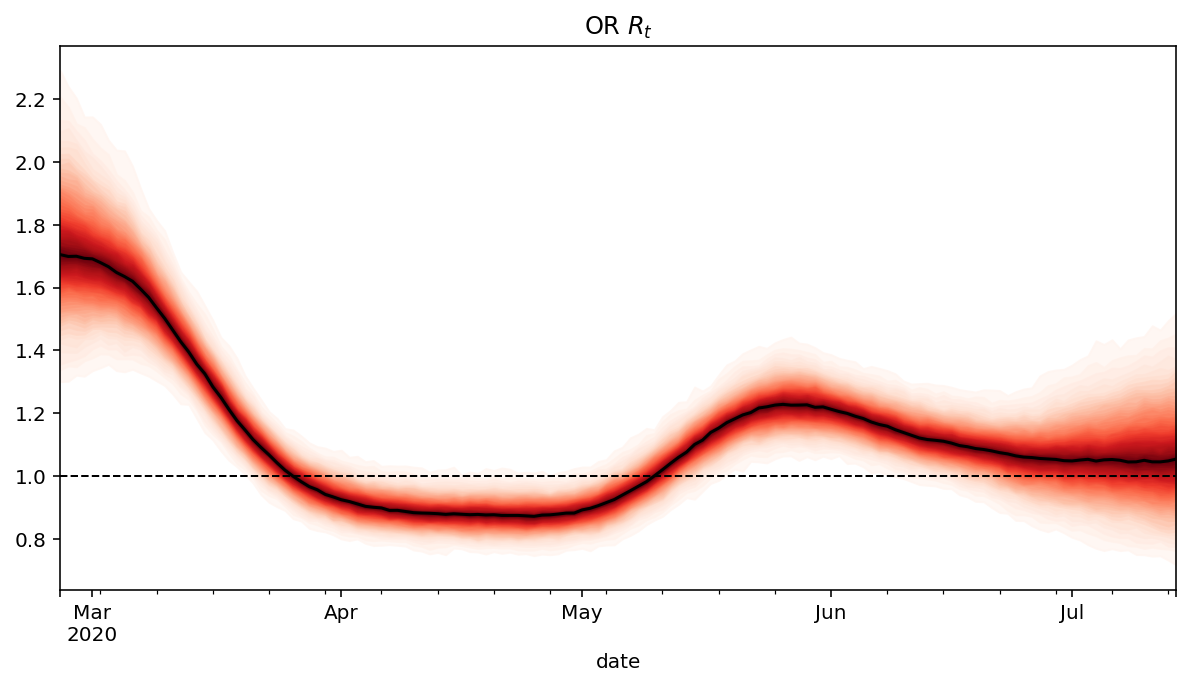

In [9]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-10,20200710,46284.0,4221.0,87033.0,21386.0,2579.0,3273.0,1168.0,8676.0,76067.0,0.0,250687,https://twitter.com/nicd_sa/status/12816671095...
2020-07-11,20200711,48232.0,4679.0,93044.0,23753.0,2835.0,3621.0,1266.0,9418.0,77336.0,0.0,264184,https://twitter.com/nicd_sa/status/12820534758...
2020-07-12,20200712,50300.0,5224.0,98431.0,25572.0,3014.0,3977.0,1401.0,9924.0,78399.0,0.0,276242,https://twitter.com/DrZweliMkhize/status/12824...
2020-07-13,20200713,52058.0,5632.0,103713.0,27387.0,3316.0,4299.0,1522.0,10525.0,79344.0,0.0,287796,https://twitter.com/DrZweliMkhize/status/12827...
2020-07-14,20200714,53959.0,5973.0,107070.0,30587.0,3458.0,4576.0,1579.0,10784.0,80199.0,107.0,298292,https://sacoronavirus.co.za/2020/07/14/update-...


In [11]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-10,20200710,2057232.0,118232,NaN,NaN,NaN,3860,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/10/update-...
2020-07-11,20200711,2108570.0,127715,NaN,NaN,NaN,3971,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/11/update-...
2020-07-12,20200712,2154391.0,134874,NaN,NaN,NaN,4079,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/12/update-...
2020-07-13,20200713,2194624.0,138241,NaN,NaN,NaN,4172,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/13/update-...
2020-07-14,20200714,2232738.0,146279,NaN,NaN,NaN,4346,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/14/update-...


## Cleanup data

In [12]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-10    250687
2020-07-11    264184
2020-07-12    276242
2020-07-13    287796
2020-07-14    298292
Name: cases, Length: 130, dtype: int64

In [13]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-14 00:00:00'))

In [14]:
idx = pd.date_range(casezero, caselast)

In [15]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-07-10    2057232.0
2020-07-11    2108570.0
2020-07-12    2154391.0
2020-07-13    2194624.0
2020-07-14    2232738.0
Name: tests, Length: 137, dtype: float64

In [16]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-10    2057232.0
2020-07-11    2108570.0
2020-07-12    2154391.0
2020-07-13    2194624.0
2020-07-14    2232738.0
Name: tests, Length: 128, dtype: float64

In [17]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-10,250687.0,2057232.0
2020-07-11,264184.0,2108570.0
2020-07-12,276242.0,2154391.0


In [18]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [19]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-10,250687.0,2057232.0
2020-07-11,264184.0,2108570.0
2020-07-12,276242.0,2154391.0
2020-07-13,287796.0,2194624.0


In [20]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-10,250687.0,2057232.0
2020-07-11,264184.0,2108570.0
2020-07-12,276242.0,2154391.0
2020-07-13,287796.0,2194624.0


In [21]:
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-10,250687.0,2057232.0,12348.0,56663.0
2020-07-11,264184.0,2108570.0,13497.0,51338.0
2020-07-12,276242.0,2154391.0,12058.0,45821.0
2020-07-13,287796.0,2194624.0,11554.0,40233.0


In [22]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-07-10,250687.0,2057232.0,12348.0,56663.0
2020-07-11,264184.0,2108570.0,13497.0,51338.0
2020-07-12,276242.0,2154391.0,12058.0,45821.0
2020-07-13,287796.0,2194624.0,11554.0,40233.0


## Calculate Rt

In [23]:
region = 'Total RSA'

In [24]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [09:46<00:00,  6.14draws/s]


## Show results

In [25]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 358.01it/s]


In [26]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-05,1.132765,1.116539,0.949048,1.310483,6743.951871,7057.414812,7108.401077,8773.0,38083.0
2020-07-06,1.134608,1.127470,0.934146,1.313557,6929.942398,7248.950689,8153.724352,8971.0,33950.0
2020-07-07,1.135087,1.124894,0.931425,1.320717,7124.787957,7442.992527,7201.716584,10134.0,43421.0
2020-07-08,1.137106,1.123529,0.921898,1.324158,7330.891681,7640.011545,7373.828912,8810.0,36867.0
2020-07-09,1.137400,1.124135,0.941018,1.364404,7549.770597,7840.760239,7511.836023,13674.0,56170.0
2020-07-10,1.137914,1.123796,0.920129,1.360765,7783.256168,8046.306543,6724.376223,12348.0,56663.0
2020-07-11,1.138225,1.127645,0.897370,1.338827,8031.776122,8257.674224,8112.472724,13497.0,51338.0
2020-07-12,1.137468,1.127727,0.920916,1.377078,8295.633720,8475.687872,8120.180141,12058.0,45821.0
2020-07-13,1.139266,1.130472,0.904539,1.381072,8576.293946,8701.170337,8861.452081,11554.0,40233.0


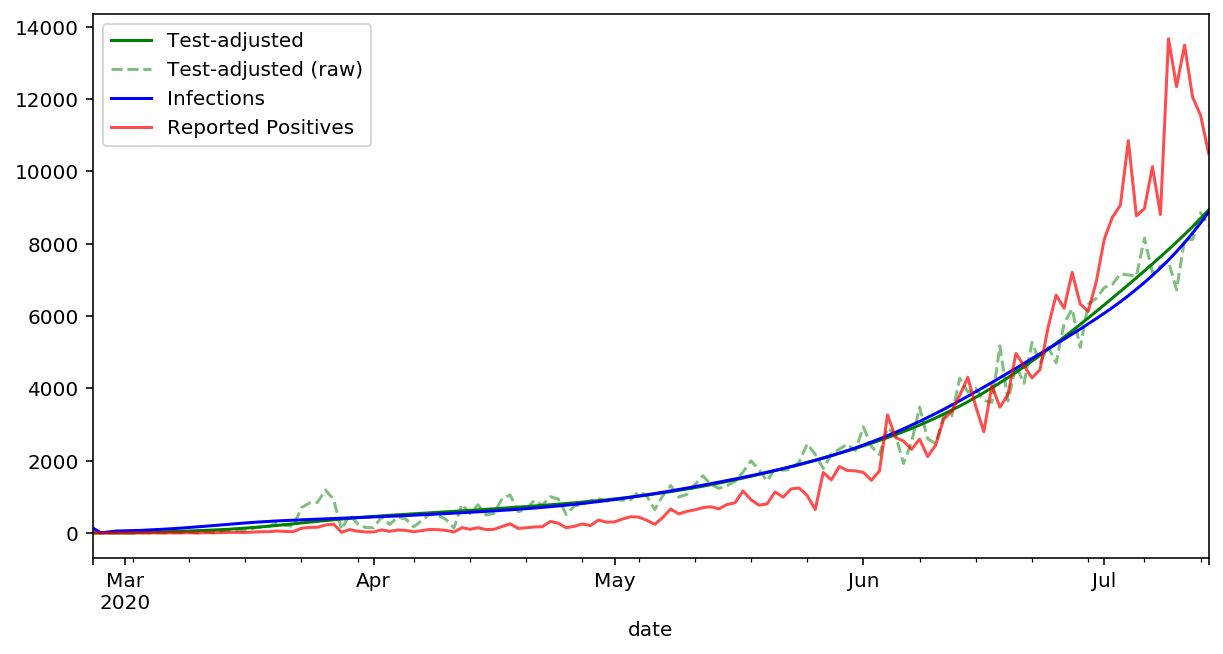

In [27]:
plot_results()

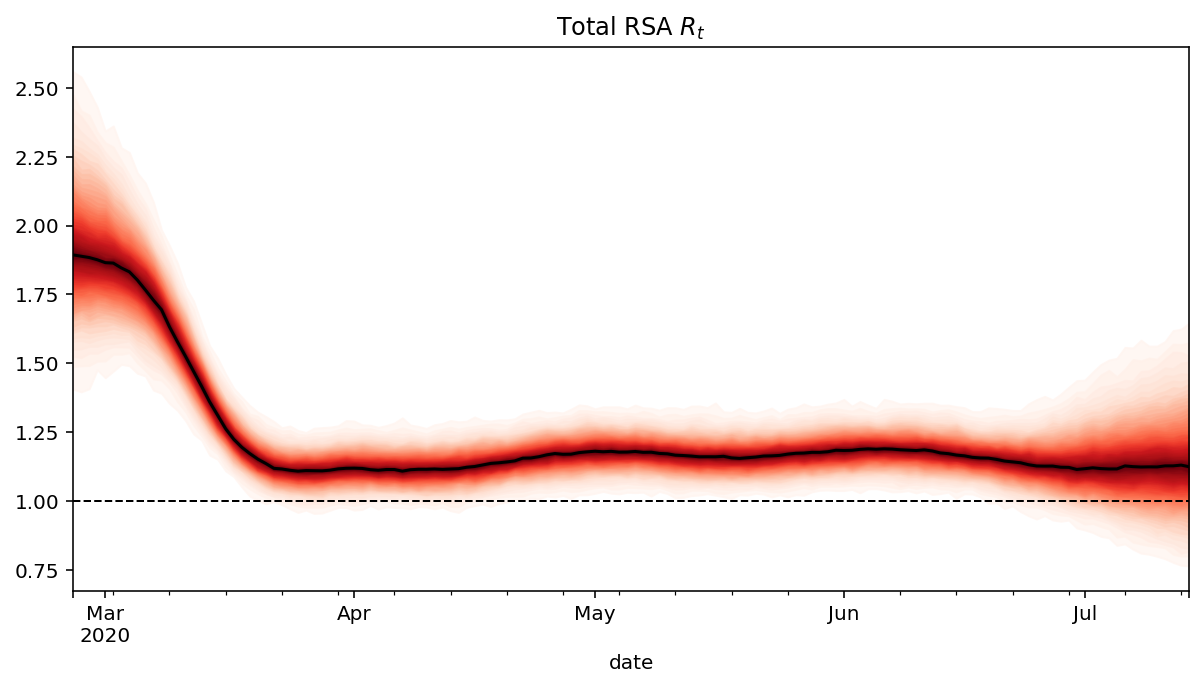

In [28]:
plot_rt()

In [29]:
export_results = result[['median','upper_80','lower_80']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80'})
export_results.tail()

,Median,High_80,Low_80
date,,,
2020-07-10,1.123796,1.360765,0.920129
2020-07-11,1.127645,1.338827,0.897370
2020-07-12,1.127727,1.377078,0.920916
2020-07-13,1.130472,1.381072,0.904539
2020-07-14,1.124530,1.373291,0.876859


## Export results

In [30]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')